## Notebook for testing the computaional limits of the GFE

#### Technical Specifications of the GFE considered for this study:
- Processor (CPU): Model: Intel Core i7-1185G7, Speed: 3.00 GHz, Number of cores: Quad-core (4 cores)
- Memory (RAM): Capacity: 16.0 GB (15.7 GB usable), Type: DDR4, Speed: 4.2 GHz
- Storage: Type: SSD, Capacity: 512 GB, 
- Graphics Card (GPU): Type: Integrated, Model: Intel(R) Iris(R) Xe Graphics, Memory: 8 GB 
- Operating System: OS Name: Windows 11, System type: 64-bit operating system, x64-based processor

### The following images shows the usage of Memory and CPU when there is no application is running on GFE

<img src="../images/RAM_startup.png" alt="Image 1" style="width: 48%; margin-right: 2%;" />
<img src="..\images\CPU_startup.png" alt="Image 2" style="width: 48%;" />


### The following images shows the usage of Memory and CPU when Google chrome, MS Teams and MS Outlook were running on GFE

<img src="https://github.com/HHS/ACF_NLP_GFE_Testing/blob/main/images/Ram_browser_team_outlook.png" alt="Image 1" style="width: 48%; margin-right: 2%;" /><img src="https://github.com/HHS/ACF_NLP_GFE_Testing/blob/main/images/CPU_browser_team_outlook.png" alt="Image 2" style="width: 48%;" />

#### Testing of the GFE was performed on top of basic usage, ~6 GB of Memory and ~80% of CPU is available for testing

### Dataset:
- Publicly available COVID dataset was used for this study, dataset can be downloaded from the below link:
- https://data.cdc.gov/Case-Surveillance/COVID-19-Case-Surveillance-Public-Use-Data/vbim-akqf/about_data
- The dataset was downloaded to the local drive on GFE (VPN needs to be turned off)
- The dataset contains 106 Million recordrs/rows, 12 fields/columns
- The actual size of the dataset is 13.8 GB
### This jupyter notebook was ran to perform machine learning models on the COVID dataset.
### Several simulations were performed by varying the number of records to process was varied from 0.1 to 100 Million.
### Processing times and computational load on the GFE recorded for each experiment.

In [1]:
# Importing necessary libraries
import time 
# Time at which the processing starts 
start_time=time.time()

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# displaying maximum number of columns and rows to display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

In [2]:
# Select the number of records to consider in the analysis 
no_of_rows_load = 100000  ## 0.1 Million
# no_of_rows_load = 1000000 ## 1 Million 
# no_of_rows_load = 10000000 ## 10 Million
# no_of_rows_load = 30000000  ## 30 million
# no_of_rows_load = 50000000  ## 50 million 
# no_of_rows_load = 100000000  ## 100 million 

In [3]:
# reading the COVID data file
file=r'C:\Users\sankar.kalaga\OneDrive - HHS Office of the Secretary\Desktop\NLP_GFE\NLP\NLP_GFE_limits\covid_data\data\COVID-19_Case_Surveillance_Public_Use_Data_with_Geography_20240403.csv'
covid_data=pd.read_csv(file, nrows=no_of_rows_load)
covid_data.head()

,case_month,res_state,state_fips_code,res_county,county_fips_code,age_group,sex,race,ethnicity,case_positive_specimen_interval,case_onset_interval,process,exposure_yn,current_status,symptom_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn
0,2020-11,WI,55,JUNEAU,55057.0,18 to 49 years,NaN,NaN,NaN,NaN,0.0,Missing,Missing,Laboratory-confirmed case,Symptomatic,No,Missing,NaN,NaN
1,2022-07,CA,6,NEVADA,6057.0,0 - 17 years,Female,NaN,NaN,NaN,0.0,Missing,Missing,Laboratory-confirmed case,Symptomatic,Missing,Missing,Missing,NaN
2,2022-02,GA,13,BULLOCH,13031.0,18 to 49 years,Female,Unknown,Missing,NaN,0.0,Missing,Missing,Laboratory-confirmed case,Symptomatic,Missing,Missing,Missing,NaN
3,2020-04,SC,45,RICHLAND,45079.0,18 to 49 years,Female,NaN,NaN,NaN,0.0,Missing,Missing,Laboratory-confirmed case,Symptomatic,No,Missing,No,NaN
4,2021-10,MI,26,SANILAC,26151.0,18 to 49 years,Female,NaN,NaN,NaN,NaN,Missing,Missing,Laboratory-confirmed case,Missing,Missing,Missing,Unknown,NaN


In [4]:
# Checking the data types 
print('Data types of the each column:')
covid_data.dtypes

Data types of the each column:


case_month                          object
res_state                           object
state_fips_code                      int64
res_county                          object
county_fips_code                   float64
age_group                           object
sex                                 object
race                                object
ethnicity                           object
case_positive_specimen_interval    float64
case_onset_interval                float64
process                             object
exposure_yn                         object
current_status                      object
symptom_status                      object
hosp_yn                             object
icu_yn                              object
death_yn                            object
underlying_conditions_yn            object
dtype: object

In [5]:
# Pre-processing and cleaning:
string_columns = ['res_state', 'res_county', 'age_group', 'sex', 'race', 'ethnicity','current_status', 'symptom_status', 'hosp_yn', 'icu_yn', 'death_yn', 'underlying_conditions_yn']
# Casting the columns to string type
covid_data[string_columns] = covid_data[string_columns].astype(str)
# Filling the NANs with "Missing"
covid_data[string_columns] = covid_data[string_columns].replace('nan', 'Missing')
# Explicitly cast numeric columns before filling missing values
numeric_columns = ['state_fips_code', 'county_fips_code', 'case_positive_specimen_interval', 'case_onset_interval']
# Casting the columns to float type
covid_data[numeric_columns] = covid_data[numeric_columns].astype(float)
# Filling the NANs with -1 or "Missing" 
covid_data.fillna({'county_fips_code': -1,
                   'case_positive_specimen_interval': -1,
                   'case_onset_interval': -1,
                   'res_state': 'Missing',
                   'res_county': 'Missing',
                   'age_group': 'Missing',
                   'sex': 'Missing',
                   'race': 'Missing',
                   'ethnicity': 'Missing',
                   'current_status': 'Missing',
                   'symptom_status': 'Missing',
                   'hosp_yn': 'Missing',
                   'icu_yn': 'Missing',
                   'death_yn': 'Missing',
                   'underlying_conditions_yn': 'Missing'}, inplace=True)

# Convert date columns to datetime
covid_data['case_month'] = pd.to_datetime(covid_data['case_month'])


In [6]:
# Confirming the casted data types 
print('Data types of the each column:')
covid_data.dtypes

Data types of the each column:


case_month                         datetime64[ns]
res_state                                  object
state_fips_code                           float64
res_county                                 object
county_fips_code                          float64
age_group                                  object
sex                                        object
race                                       object
ethnicity                                  object
case_positive_specimen_interval           float64
case_onset_interval                       float64
process                                    object
exposure_yn                                object
current_status                             object
symptom_status                             object
hosp_yn                                    object
icu_yn                                     object
death_yn                                   object
underlying_conditions_yn                   object
dtype: object

In [7]:
# Display cleaned data
covid_data[covid_data['county_fips_code']==-1]

,case_month,res_state,state_fips_code,res_county,county_fips_code,age_group,sex,race,ethnicity,case_positive_specimen_interval,case_onset_interval,process,exposure_yn,current_status,symptom_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn
508,2022-02-01,MD,24.0,Missing,-1.0,65+ years,Female,White,Missing,-1.0,0.0,Missing,Missing,Laboratory-confirmed case,Symptomatic,Missing,Missing,No,Missing
779,2021-12-01,AZ,4.0,Missing,-1.0,65+ years,Female,Missing,Missing,-1.0,-1.0,Missing,Missing,Laboratory-confirmed case,Missing,Missing,Missing,No,Missing
837,2023-12-01,HI,15.0,Missing,-1.0,18 to 49 years,Female,Asian,Missing,-1.0,0.0,Missing,Missing,Laboratory-confirmed case,Symptomatic,Missing,Missing,Missing,Missing
932,2022-07-01,TX,48.0,Missing,-1.0,50 to 64 years,Female,Black,Unknown,-1.0,-1.0,Missing,Missing,Probable Case,Missing,No,Missing,Missing,Missing
1778,2021-12-01,ME,23.0,Missing,-1.0,65+ years,Female,Missing,Missing,0.0,-1.0,Missing,Missing,Laboratory-confirmed case,Missing,Missing,Missing,No,Missing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98714,2023-08-01,HI,15.0,Missing,-1.0,65+ years,Male,Missing,Missing,-1.0,-1.0,Missing,Missing,Laboratory-confirmed case,Missing,Missing,Missing,Missing,Missing
98857,2021-03-01,MD,24.0,Missing,-1.0,50 to 64 years,Female,Missing,Missing,-1.0,-1.0,Missing,Missing,Laboratory-confirmed case,Missing,Missing,Missing,Missing,Missing
99007,2020-12-01,NM,35.0,Missing,-1.0,18 to 49 years,Male,Unknown,Hispanic/Latino,-1.0,-1.0,Missing,Missing,Laboratory-confirmed case,Missing,Missing,Missing,Missing,Missing
99734,2022-07-01,AZ,4.0,Missing,-1.0,50 to 64 years,Male,Missing,Missing,-1.0,-1.0,Missing,Missing,Laboratory-confirmed case,Missing,Missing,Missing,Missing,Missing


In [8]:
# Fields of interest for performing classification model
covid_data[["current_status","symptom_status"]]

,current_status,symptom_status
0,Laboratory-confirmed case,Symptomatic
1,Laboratory-confirmed case,Symptomatic
2,Laboratory-confirmed case,Symptomatic
3,Laboratory-confirmed case,Symptomatic
4,Laboratory-confirmed case,Missing
...,...,...
99995,Laboratory-confirmed case,Symptomatic
99996,Laboratory-confirmed case,Missing
99997,Laboratory-confirmed case,Symptomatic
99998,Laboratory-confirmed case,Symptomatic


In [9]:
# Assuming symptom_status has been cleaned to remove 'Missing' entries
data = covid_data[covid_data['symptom_status'] != 'Missing']
print('actual number of records condiered for the analysis:', data.shape[0])
# print(data.shape)
# checking the number of uniques values in the "symptom_status" column
data["symptom_status"].value_counts()


actual number of records condiered for the analysis: 50808


symptom_status
Symptomatic     40420
Unknown          8936
Asymptomatic     1452
Name: count, dtype: int64

In [10]:
# Converting the text fields to numeric values
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['symptom_status'])
y = data['current_status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Train the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_res, y_train_res)

# Predict and evaluate
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))

                           precision    recall  f1-score   support

Laboratory-confirmed case       0.78      0.80      0.79      7841
            Probable Case       0.25      0.22      0.23      2321

                 accuracy                           0.67     10162
                macro avg       0.51      0.51      0.51     10162
             weighted avg       0.66      0.67      0.66     10162



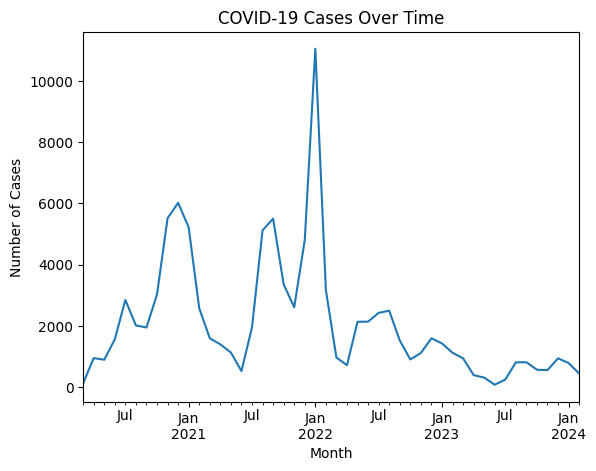

In [11]:
# Group by case_month and count occurrences
monthly_cases = covid_data.groupby(covid_data['case_month'].dt.to_period('M')).size()
# Plot trends over the period of each month
monthly_cases.plot(kind='line')
plt.title('COVID-19 Cases Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Cases')
plt.show()


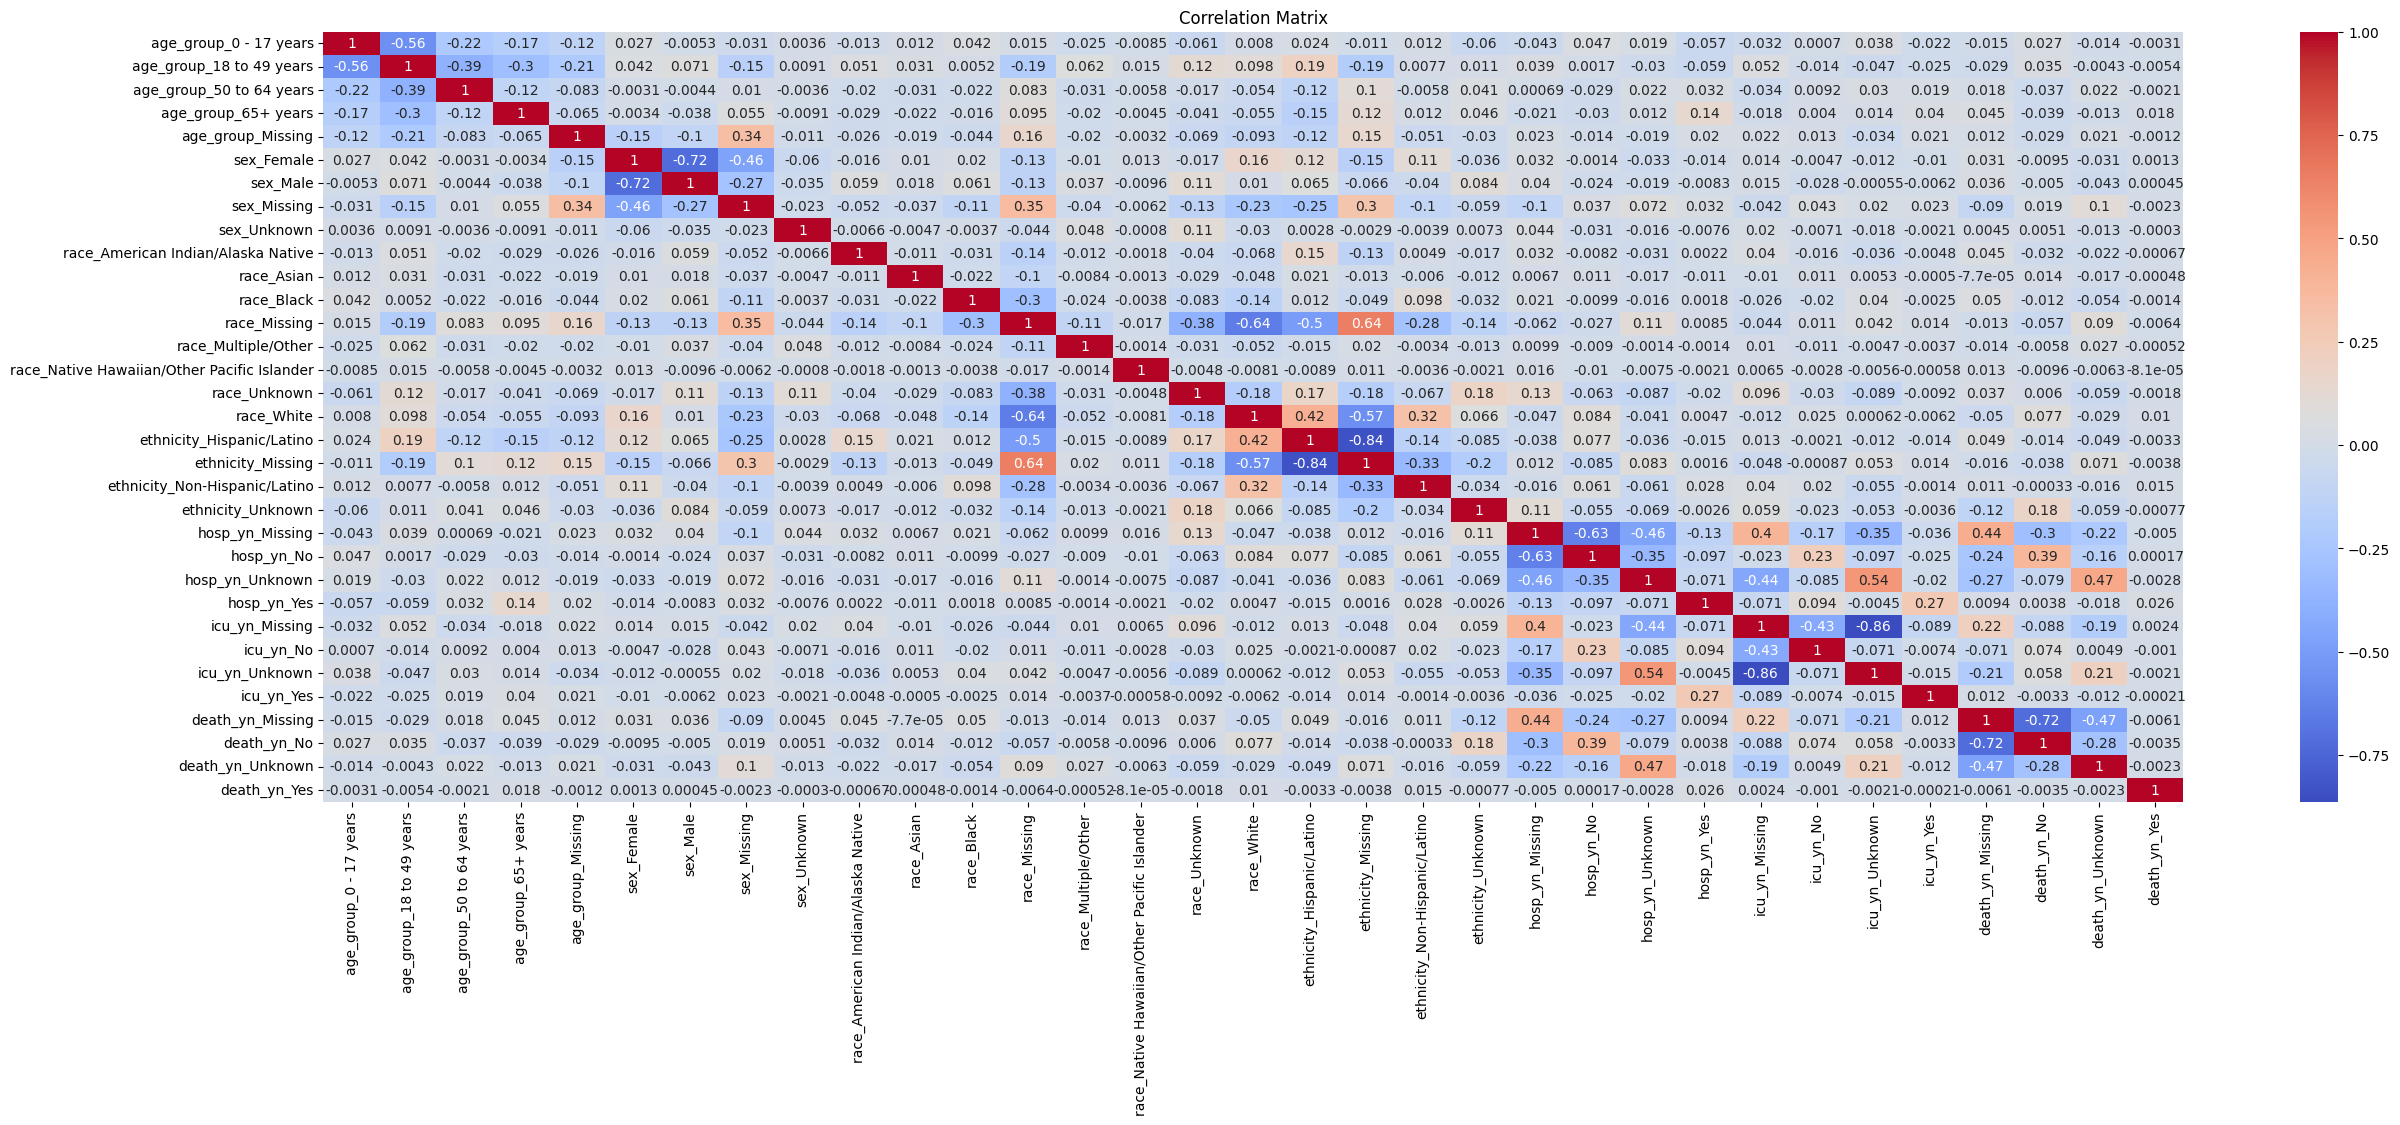

In [12]:
# Convert categorical data to numeric for correlation
numeric_data = pd.get_dummies(covid_data[['age_group', 'sex', 'race', 'ethnicity', 'hosp_yn', 'icu_yn', 'death_yn']])

# Calculate correlation matrix
correlation_matrix = numeric_data.corr()

# Plot the correlation heatmap
plt.figure(figsize=(30, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [13]:
# Encode categorical variables
encoded_data = pd.get_dummies(covid_data[['age_group', 'sex', 'race', 'ethnicity']])

# KMeans clustering
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(encoded_data)

# Add cluster labels to the original dataset
covid_data['cluster'] = clusters

# Display cluster counts
print(covid_data['cluster'].value_counts())


cluster
2    28130
1    23009
3    22059
4    14962
0    11840
Name: count, dtype: int64


In [14]:
# Encode categorical variables
encoded_data = pd.get_dummies(covid_data[['age_group', 'sex', 'race', 'ethnicity', 'underlying_conditions_yn', 'hosp_yn', 'icu_yn', 'death_yn']])

# Prepare features and target
X = encoded_data.drop(columns=['death_yn_Missing', 'death_yn_No', 'death_yn_Unknown', 'death_yn_Yes'])
y = encoded_data[['death_yn_Missing', 'death_yn_No', 'death_yn_Unknown', 'death_yn_Yes']]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the RandomForestClassifier model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.74      0.77     11028
           1       0.66      0.56      0.61      5945
           2       0.61      0.46      0.52      3026
           3       0.00      0.00      0.00         1

   micro avg       0.73      0.65      0.69     20000
   macro avg       0.52      0.44      0.47     20000
weighted avg       0.73      0.65      0.68     20000
 samples avg       0.65      0.65      0.65     20000



c:\Users\sankar.kalaga\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sankar.kalaga\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
# Note the time at which simulation ends
end_time=time.time()
total_processing_time=end_time-start_time
print("Time for completing the processing:", round(total_processing_time), 'Secs')

Time for completing the processing: 12 Secs


Computational load on the GFE for 30M records:

<img src="..\images\Ram_30M.png" alt="Image 1" style="width: 48%; margin-right: 2%;" />
<img src="..\images\CPU_30M.png" alt="Image 2" style="width: 48%;" />

### Obeservations:
- Case 1:
    - No of records loaded to the notebook 0.1 M records
    - No of records actually processed by ML models  0.05 M records
    - Computational load on GFE: CPU-30%, RAM-65%
    - Time for completing the processing: 15 Secs
- Case 2:
    - No of records loaded to the notebook 1 M records
    - No of records actually processed by ML models  0.52 M records
    - Computational load on GFE: CPU-68%, RAM-68%
    - Time for completing the processing: 395 Secs
- Case 3:
    - No of records loaded to the notebook 10 M records
    - No of records actually processed by ML models  5.26 M records
    - Computational load on GFE: CPU-100%, RAM-85%
    - Time for completing the processing: 4318 Secs
- Case 4:
    - No of records loaded to the notebook 30 M records
    - No of records actually processed by ML models  15.65 M records
    - Computational load on GFE: CPU-100%, RAM-96% 
    - Time for completing the processing: 23637 Secs (~6.6 Hrs)
    - GFE freezes ocassionally
- Case 5:
    - No of records loaded to the notebook 50 M records
    - No of records actually processed by ML models  25.90 M records
    - Computational load on GFE: CPU-100 %, RAM-100%  (while loading the data)
    - GFE freezes
- Case 6:
    - Tried to load 100 M records to the notebook, GFE fails to read the 100 M records and throws the Memory Error. 
    - MemoryError: Unable to allocate 11.2 GiB for an array with shape (15, 100000000)